In [1]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

%matplotlib inline

import caffe
caffe.set_device(0)
caffe.set_mode_gpu()

In [2]:
# set all needed paths
experiment_name = 'three_users'

# models, labels and images
models_path = 'models/finetuning-googlenet/'
labels_path = '../../../data/emanuela/activity-recognition/labels/'

experiment_models_path = models_path + experiment_name + '/'
experiment_labels_path = labels_path + experiment_name + '/'

# dataset paths
labels_dataset_path = labels_path + 'labels.txt'
test_dataset_path   = experiment_labels_path + 'test.txt'

# main files for the network
activities_net = {
    'model': experiment_models_path + 'result.caffemodel',
    'deploy': models_path + 'deploy.prototxt',
}

Loading the files

In [3]:
# load images and labels

def format_line(line):
    line = line.split(' ')
    activity = line[-1]
    image_name = ' '.join(line[:-1])
    
    return [image_name, activity]

# get all labels
labels = list(np.loadtxt(labels_dataset_path, str, delimiter='\n'))

# get test images and labels
test_dataset = [ format_line(line) 
    for line in list(np.loadtxt(test_dataset_path, str, delimiter='\n'))
]

test_paths, test_labels = zip(*[(path, int(label)) for path, label in test_dataset])

NUM_LABELS = len(labels)
print "%i labels loaded" % NUM_LABELS
print "%i test images" % (len(test_paths))

21 labels loaded
6750 test images


Loading the classifiar, and setting up the caffe preprocessor in order to load images one by one instead of by batches, it will be slower but we can play around with the data

In [5]:
# loads activities net 
activitiesnet = caffe.Classifier(activities_net['deploy'], activities_net['model'], caffe.TEST)
activitiesnet.blobs['data'].reshape(1,3,227,227)

# preprocessing for caffe inputs
transformer = caffe.io.Transformer({'data': activitiesnet.blobs['data'].data.shape})
transformer.set_transpose('data', (2,0,1))
transformer.set_channel_swap('data', (2,1,0))
transformer.set_raw_scale('data', 255.0)

In [29]:
def get_predictions(net, labels, image_path, top = 5):
    """This function recieves a net and an image_path, and returns the top prediction/s"""
    im = caffe.io.load_image(image_path)
    net.blobs['data'].data[...] = transformer.preprocess('data', im)
    out = net.forward()
    layer = 'prob'
    if not layer in net.blobs:
        layer = 'probs'
        
    if top == 1:
        top = np.sort(net.blobs[layer].data[0].flatten())[-1:]
        top_index = net.blobs[layer].data[0].flatten().argsort()[-1:]
    else:
        top = np.sort(net.blobs[layer].data[0].flatten())[-1:-6:-1]
        top_index = net.blobs[layer].data[0].flatten().argsort()[-1:-6:-1]
    
    result = {}
    result['image'] = image_path
    result['result'] = []
    for i in range(len(top_index)):
        result['result'].append((labels[top_index[i]], top[i]))
        
    return result

Let's display a prediction to show that everything works

Label:  reading

Best prediction
('reading', 0.62085032)
('working', 0.2043242)
('having drinks/meal alone', 0.049877677)
('meeting', 0.045683101)
('mobile', 0.029786468)

Best 5 predictions
('reading', 0.62085032)
('working', 0.2043242)
('having drinks/meal alone', 0.049877677)
('meeting', 0.045683101)
('mobile', 0.029786468)


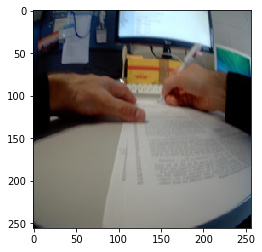

In [44]:
from scipy import misc
import random

def disp_predictions(net, labels, image_path, top = 5):
    """This function recieves a net and an image_path, and returns the top prediction/s"""
    result = get_predictions(net, labels, image_path, top)
    
    plt.imshow(misc.imread(image_path))
    for tuple in result['result']:
        print(tuple)

index = random.randint(0, len(test_paths))
print "Label: ", labels[test_labels[index]]
print "\nBest prediction"
disp_predictions(activitiesnet, labels,  test_paths[index])
print "\nBest 5 predictions"
disp_predictions(activitiesnet, labels,  test_paths[index], 5)

In [45]:
all_results = []
for index in range(0, len(test_paths)):
    prediction = get_predictions(activitiesnet, labels, test_paths[index])
    prediction['label'] = labels[test_labels[index]]
    all_results.append(prediction)

import pickle
with open(experiment_models_path + 'outfile', 'wb') as fp:
    pickle.dump(all_results, fp)

Now we will splitt the test dataset into cattegories, to test all of them alone

In [7]:
paths = [[] for _ in range(NUM_LABELS)]
# each index index paths will contain a list of  pictures associated to a category
for i, path in enumerate(test_paths):
    paths[test_labels[i]].append(path)

# number of images per category
print [len(examples) for examples in paths]

[238, 457, 507, 262, 34, 199, 237, 160, 270, 153, 273, 188, 229, 130, 1036, 80, 193, 413, 804, 739, 148]


Let's show a plot with the numer of images per category

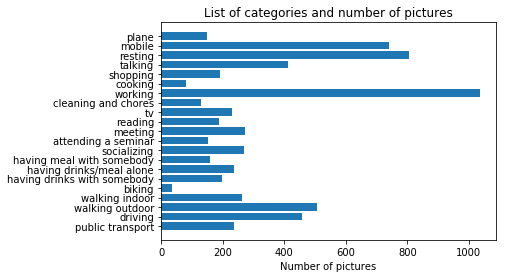

In [8]:
y_pos = np.arange(NUM_LABELS)
num_examples = [len(examples) for examples in paths]
plt.barh(y_pos, num_examples,  alpha=1)
plt.yticks(y_pos, labels)
plt.xlabel('Number of pictures')
plt.title('List of categories and number of pictures')
plt.show()

Let's test the accuracy for each category

In [9]:
def eval_category(net, category, label, layer='probs'):
    correct = 0.
    for path in category:
        processed_image = im = caffe.io.load_image(path)
        net.blobs['data'].data[...] = transformer.preprocess('data', processed_image)
        out = net.forward()
        top_label = net.blobs[layer].data[0].flatten().argsort()[-1]
        if top_label == label:
            correct += 1
    if len(category) == 0:
        return 0
    return correct / len(category)
        
def eval_categories(net, categories):
    """evaluates the net"""
    accuracies = np.zeros(len(categories))
    for i, category in enumerate(categories):
        print i
        accuracies[i] = eval_category(net,category, i )
    return accuracies * 100

accuracies = eval_categories(activitiesnet, paths)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


In [10]:
for i, acc in enumerate(accuracies):
    print "%s: %i" %(labels[i], acc)

public transport: 87
driving: 98
walking outdoor: 90
walking indoor: 67
biking: 76
having drinks with somebody: 80
having drinks/meal alone: 80
having meal with somebody: 80
socializing: 81
attending a seminar: 90
meeting: 75
reading: 85
tv: 90
cleaning and chores: 63
working: 94
cooking: 72
shopping: 74
talking: 78
resting: 90
mobile: 84
plane: 87


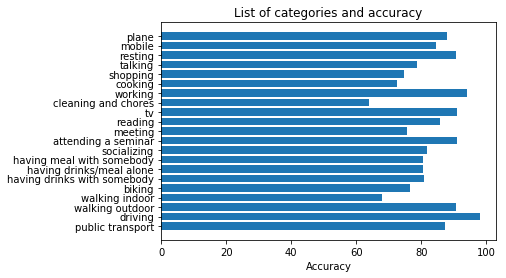

In [11]:
y_pos = np.arange(NUM_LABELS)
plt.barh(y_pos, accuracies,  alpha=1)
plt.yticks(y_pos, labels)
plt.xlabel('Accuracy')
plt.title('List of categories and accuracy')
plt.show()

In [12]:
def eval_global(net, paths, labels, layer='probs'):
    top_labels = np.zeros((len(paths)))
    for i, path in enumerate(paths):
        processed_image = im = caffe.io.load_image(path)
        net.blobs['data'].data[...] = transformer.preprocess('data', processed_image)
        out = net.forward()
        top_labels[i] = net.blobs[layer].data[0].flatten().argsort()[-1]
        
    return np.count_nonzero(top_labels == labels) / float(len(paths)) * 100., top_labels



def show_confusion_matrix(true_labels, top_labels, labels):
    # confusion matrix
    matrix = confusion_matrix(true_labels, top_labels)
    # normalize confutsion matrix
    num_per_class , _ = np.histogram(test_labels, len(labels))
    for i, row in enumerate(matrix):
        if num_per_class[i] == 0:
            matrix[i] = (matrix[i] + 0.00001) * 100.  / 0.00001
        else:
            matrix[i] = matrix[i] * 100.  / num_per_class[i]
    
    

    norm_conf = []
    for i in matrix:
        a = 0
        tmp_arr = []
        a = sum(i, 0)
        for j in i:
            if float(a) == 0:
                tmp_arr.append(float(j)/(float(a) + 0.00001))
            else:
                tmp_arr.append(float(j)/float(a))
        norm_conf.append(tmp_arr)

    fig = plt.figure(figsize=(10,7))
    plt.clf()
    ax = fig.add_subplot(111)
    ax.set_aspect(1)
    res = ax.imshow(np.array(norm_conf), cmap=plt.cm.GnBu, 
                    interpolation='nearest')

    width, height = matrix.shape

    for x in xrange(width):
        for y in xrange(height):
            ax.annotate(str(matrix[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center')

    cb = fig.colorbar(res)
    alphabet = labels
    ax.xaxis.tick_top()
    plt.xticks(range(width), alphabet[:width], rotation='vertical')
    plt.yticks(range(height), alphabet[:height])


In [13]:
glob_accuracy, top_labels = eval_global(activitiesnet, test_paths, test_labels)

Global accuracy of the cnn:  86% 
['public transport', 'driving', 'walking outdoor', 'walking indoor', 'biking', 'having drinks with somebody', 'having drinks/meal alone', 'having meal with somebody', 'socializing', 'attending a seminar', 'meeting', 'reading', 'tv', 'cleaning and chores', 'working', 'cooking', 'shopping', 'talking', 'resting', 'mobile', 'plane']


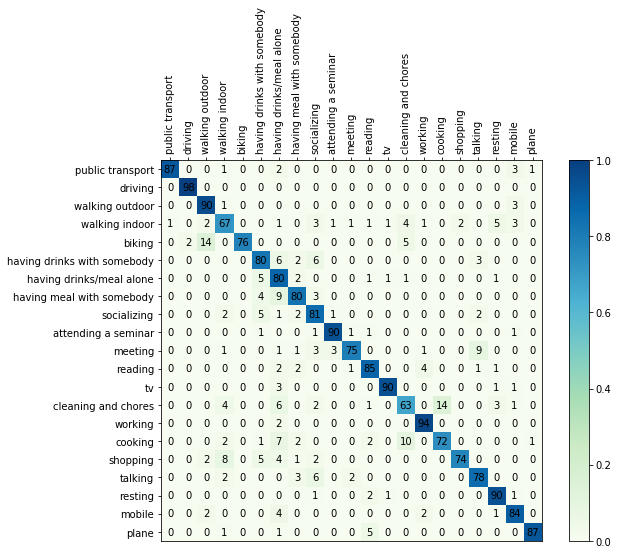

In [14]:
print "Global accuracy of the cnn:  %2.f%% " %(glob_accuracy)
print(labels)
show_confusion_matrix(test_labels, top_labels, labels)